In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import StandardScaler
import re

In [4]:
df = pd.read_csv('../data/full_data_2011-01-01_2022-11-26.csv', sep=',')
df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['energie']
df['The_date'] = df['energie']

In [5]:
dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}
for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    the_date = f'{day}-{month}-{year}'
    df['The_date'].iloc[i] = the_date
df['The_date'] = pd.to_datetime(df['The_date'])

In [6]:
df_rain = pd.read_csv('../data/data_precipitation.csv', sep=';')
df_temp= pd.read_csv('../data/temperature_data.csv', sep=';')
df_temp.drop(columns=['Unnamed: 17'], inplace = True)
df = df[2557:-18]
df.reset_index(inplace = True)

In [7]:
df_rain['mean'] = df_rain.mean(axis=1)
df_temp['mean'] = df_temp.mean(axis=1)


df['rain'] = df_rain['mean']
df['temp'] = df_temp['mean']

/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_73139/1983197786.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_rain['mean'] = df_rain.mean(axis=1)
/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/ipykernel_73139/1983197786.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_temp['mean'] = df_temp.mean(axis=1)


In [14]:
df['energie_ma'] = df['energie'].rolling(14).mean()
df['rain_ma'] = df['rain'].rolling(14).mean()
df['temp_ma'] = df['temp'].rolling(14).mean()
df = df.loc[14:]

In [26]:
df_to_scale = ['energie','energie_ma','rain_ma', 'temp_ma']
scaler = StandardScaler()

for column in df_to_scale:
            df[column] = scaler.fit_transform(pd.DataFrame(df[column],columns=[column]))

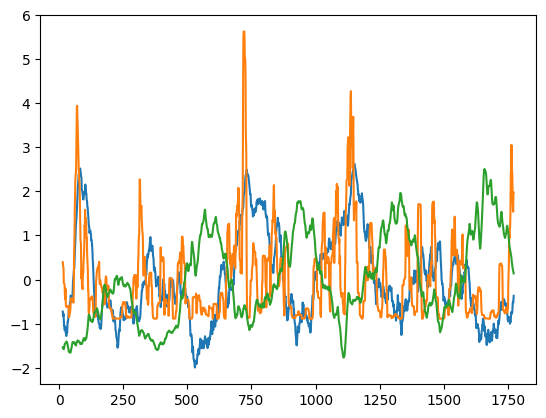

In [27]:
plt.plot(df[['energie_ma', 'rain_ma', 'temp_ma']])

In [28]:
data_train = df[:1500]
data_test = df[1500:]

In [29]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima = SARIMAX(data_train['energie_ma'], exog=data_train[['rain_ma','temp_ma']], order=(2, 1, 1), seasonal_order=(0, 0, 2, 12))
sarima = sarima.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.21030D+00    |proj g|=  8.65989D-02


 This problem is unconstrained.



At iterate    5    f= -1.21458D+00    |proj g|=  1.16374D-02

At iterate   10    f= -1.21475D+00    |proj g|=  2.36524D-01

At iterate   15    f= -1.21502D+00    |proj g|=  9.81270D-03

At iterate   20    f= -1.21504D+00    |proj g|=  1.25964D-02

At iterate   25    f= -1.21505D+00    |proj g|=  1.72622D-02

At iterate   30    f= -1.21506D+00    |proj g|=  3.46626D-03

At iterate   35    f= -1.21506D+00    |proj g|=  3.95140D-03

At iterate   40    f= -1.21511D+00    |proj g|=  2.33299D-03

At iterate   45    f= -1.21512D+00    |proj g|=  1.44246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     72   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [30]:
results = sarima.get_forecast(len(data_test), exog =data_test[['rain_ma','temp_ma']] , alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

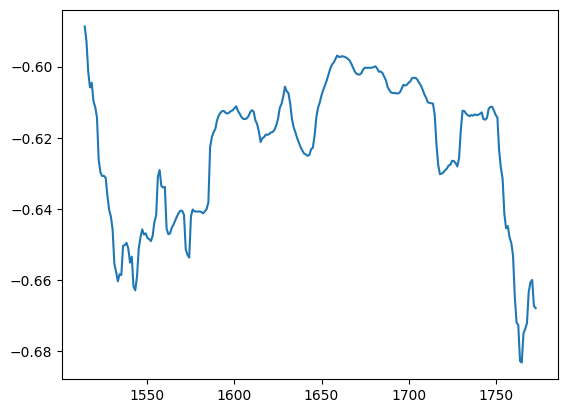

In [31]:
plt.plot(forecast)

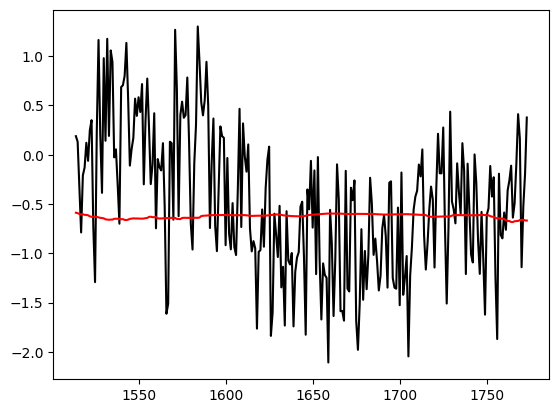

In [32]:
plt.plot(data_test['energie'], label='training', color='black')
plt.plot(forecast, label='forecast', color='red')

In [326]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);


In [355]:
data_train

,ds,y
0,2018-01-01,944.0
1,2018-02-01,2496.0
2,2018-03-01,2576.0
3,2018-04-01,1972.0
4,2018-05-01,3649.0
...,...,...
1495,2022-04-02,3116.0
1496,2022-05-02,2630.0
1497,2022-06-02,3246.0
1498,2022-07-02,1966.0


In [358]:
from prophet import Prophet

model = Prophet(seasonality_mode='multiplicative')

model.fit(data_train)

future = model.make_future_dataframe(periods=len(data_test), freq='MS')

forecast_test = model.predict(future)
forecast_test.head()

model.plot(forecast_test);

14:46:47 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing
14:46:47 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6
Optimization terminated abnormally. Falling back to Newton.
14:46:47 - cmdstanpy - INFO - Chain [1] start processing
14:46:47 - cmdstanpy - INFO - Chain [1] done processing
14:46:47 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 6 Unknown error: -6


RuntimeError: Error during optimization! Command '/Users/alexander_wynaendts/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin random seed=50234 data file=/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/tmpv7aqdj53/czvh_kiq.json init=/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/tmpv7aqdj53/4yfxn9cn.json output file=/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/tmpv7aqdj53/prophet_modelfgx_7kc4/prophet_model-20221201144647.csv method=optimize algorithm=newton iter=10000' failed: console log output:

dyld[60283]: Library not loaded: @rpath/libtbb.dylib
  Referenced from: /Users/alexander_wynaendts/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin
  Reason: tried: '/private/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/pip-install-xm9207ts/prophet_33531f5e1e314d56bb62df0d055e739a/build/lib.macosx-12.1-arm64-cpython-310/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/private/var/folders/9g/tq1twg9d6mq7h7qdcrf8krk40000gn/T/pip-install-xm9207ts/prophet_33531f5e1e314d56bb62df0d055e739a/build/lib.macosx-12.1-arm64-cpython-310/prophet/stan_model/cmdstan-2.26.1/stan/lib/stan_math/lib/tbb/libtbb.dylib' (no such file), '/usr/local/lib/libtbb.dylib' (no such file), '/usr/lib/libtbb.dylib' (no such file)
